In [1]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import dataloader, DataLoader
import matplotlib.pyplot as plt
from torch import optim
from torch import nn

from torchmetrics import Recall, Precision, Accuracy, AUROC

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((64, 64)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((64, 64))
])

In [3]:
dataset_train = ImageFolder(
    'data/Combined dataset/train', 
    transform=train_transform
)


dataset_test = ImageFolder(
    'data/Combined dataset/test', 
    transform=test_transform
)

In [4]:
dataloader_train =  DataLoader(dataset_train, 
                               batch_size = 32, 
                               shuffle= True
                               )

dataloader_test = DataLoader(dataset_test, 
                             batch_size= 32, 
                             shuffle = True
)

In [5]:
images, labels = next(iter(dataloader_train))
print(images.shape)

torch.Size([32, 3, 64, 64])


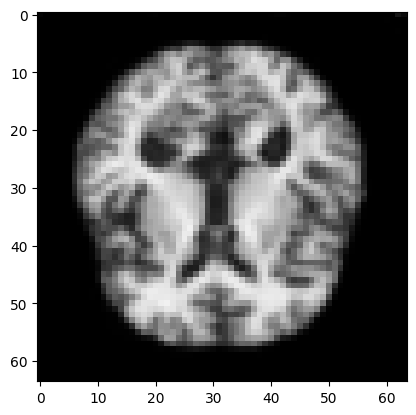

In [6]:
image = images[0]
image = image.squeeze().permute(1, 2, 0)

plt.imshow(image)

In [7]:
class Net(nn.Module): 
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, padding=1), 
            nn.ELU(), 
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(32, 64, kernel_size= 2, padding= 1), 
            nn.ELU(), 
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        self.classifier = nn.Linear(64 * 16*16, num_classes)


    def forward (self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x 

In [8]:
net = Net(num_classes= 4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr  = 0.001)

In [9]:
metric_recall = Recall(task='multiclass', num_classes=4, average='macro')
metric_precision = Precision(task='multiclass', num_classes=4, average='macro')
metric_accuracy = Accuracy(task='multiclass', num_classes=4, average='macro')
metric_recall_m = Recall(task='multiclass', num_classes=4, average=None)

In [10]:
for epoch in range (10): 
    net.train()
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    net.eval()
    with torch.no_grad():
        for images, labels in dataloader_test:
            output = net(images)
            _, pred = torch.max(output, 1)
            metric_accuracy(pred, labels)
            metric_recall(pred, labels)
            metric_precision(pred, labels)
            metric_recall_m(pred, labels)
    precision = metric_precision.compute()
    recall = metric_recall.compute()
    accuracy = metric_accuracy.compute()
    recall_m = metric_recall_m.compute()


In [11]:
print(f'Precision : {precision}')
print(f'Recall: {recall}')
print(f'Accuracy : {accuracy}')
print(f'Recall per class: {recall_m}')

Precision : 0.877330482006073
Recall: 0.8753349184989929
Accuracy : 0.8753349184989929
Recall per class: tensor([0.8268, 0.9917, 0.8619, 0.8210])


In [14]:
dataset_test.class_to_idx

{'Mild Impairment': 0,
 'Moderate Impairment': 1,
 'No Impairment': 2,
 'Very Mild Impairment': 3}

In [19]:
{
    k: recall_m[v].item()
    for k, v
    in dataset_test.class_to_idx.items()
}

{'Mild Impairment': 0.826815664768219,
 'Moderate Impairment': 0.9916666746139526,
 'No Impairment': 0.8618749976158142,
 'Very Mild Impairment': 0.8209821581840515}